<a href="https://colab.research.google.com/github/Shinju-M/Description-Request-Matching/blob/main/BERT_Match_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

In [ ]:
import pandas as pd
import numpy as np
import random
import torch
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import load_metric, Dataset
from sklearn.metrics import classification_report, f1_score
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#device = torch.device('cuda')
import tqdm

In [ ]:
from torch.utils.tensorboard import SummaryWriter

torch.manual_seed(1000)

writer = SummaryWriter()

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from string import punctuation
import re
nltk.download('stopwords')
stop_ru = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!wget https://raw.githubusercontent.com/Shinju-M/Description-Request-Matching/main/datasets/data_train.csv
!wget https://raw.githubusercontent.com/Shinju-M/Description-Request-Matching/main/datasets/data_test.csv

In [ ]:
# train data
train_df = pd.read_csv('data_train.csv', sep = ',', index_col=False)
train_profiles = train_df['profile'].astype('str')
train_requests = train_df['text'].astype('str')
train_labels_bin = train_df['match_bin']
train_labels_cat = train_df['match_cat'].apply(lambda x: x - 1)

In [ ]:
# test data
test_df = pd.read_csv('data_test.csv', sep = ',')
test_profiles = test_df['profile'].astype('str')
test_requests = test_df['text'].astype('str')
test_labels_bin = test_df['match_bin']
test_labels_cat = test_df['match_cat'].apply(lambda x: x - 1)

Preprocessing

In [ ]:
# clean function

# def clean_text(text):
#   text = re.sub(r'[,.?“/!@#$:#—ツ►๑۩۞۩•*”˜˜”*°°*`)"(]', '', text)
#   text = [word.strip().lower() for word in text.split()]
#   return ' '.join(text)

In [ ]:
# clean and lemmatize function
# import pymystem3
# m = pymystem3.Mystem()

# def clean_text(text):
#   text = re.sub(r'[,.?“/!@#$:#—ツ►๑۩۞۩•*”˜˜”*°°*`)"(]', '', text)
#   text = [word.strip().lower() for word in m.lemmatize(text)]
#   return ' '.join(text)

In [ ]:
# simplier clean for BERT

def clean_text(text):
  text = re.sub(r'\n', ' ', text)
  text = re.sub(r'"', '', text)
  return text

In [ ]:
# train data cleaning
train_profiles_clean = []
for text in train_profiles:
  text = clean_text(text)
  train_profiles_clean.append(text)

train_df['profile'] = train_profiles_clean

train_requests_clean = []
for text in train_requests:
  text = clean_text(text)
  train_requests_clean.append(text)

train_df['text'] = train_requests_clean

In [ ]:
# test data cleaning
test_profiles_clean = []
for text in test_profiles:
  text = clean_text(text)
  test_profiles_clean.append(text)

test_df['profile'] = test_profiles_clean

test_requests_clean = []
for text in test_requests:
  text = clean_text(text)
  test_requests_clean.append(text)

test_df['text'] = test_requests_clean

In [ ]:
# train_df.to_csv('data_train.csv')
# test_df.to_csv('data_test.csv')

<Axes: >

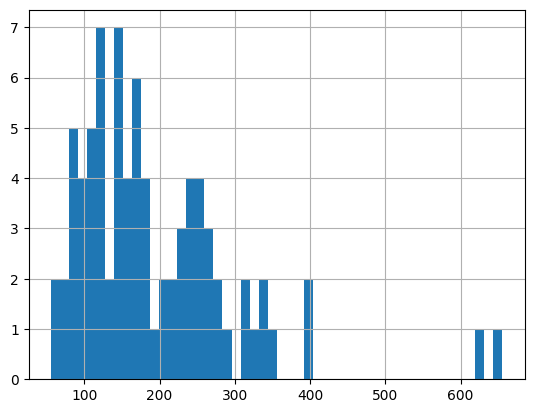

In [ ]:
# text length distribution graph

# seq_len = [len(str(i).split()) for i in train_pairs]
# pd.Series(seq_len).hist(bins = 50)

BERT

In [ ]:
bert = AutoModel.from_pretrained('ai-forever/ruBert-base')

tokenizer = BertTokenizer.from_pretrained('ai-forever/ruBert-base')

config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/716M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

In [ ]:
batch_size = 8

In [ ]:
MAX_LEN = 512

In [ ]:
# train data prep
train_tokens = tokenizer(
    train_df['text'].tolist(),
    train_df['profile'].tolist(),
    max_length = MAX_LEN,
    padding = 'max_length',
    truncation = True
)

train_seq = torch.tensor(train_tokens['input_ids'])
train_mask = torch.tensor(train_tokens['attention_mask'])
train_y = torch.tensor(train_labels_cat.values, dtype=torch.long)

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_seq)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

In [ ]:
test_tokens = tokenizer(
    test_df['text'].tolist(),
    test_df['profile'].tolist(),
    max_length = MAX_LEN,
    padding = 'max_length',
    truncation = True
)

test_seq = torch.tensor(test_tokens['input_ids'])
test_mask = torch.tensor(test_tokens['attention_mask'])
test_y = torch.tensor(test_labels_cat.values, dtype=torch.long)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = RandomSampler(test_seq)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = batch_size)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


In [ ]:
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,5)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [ ]:
model = BERT_Arch(bert)

# model = model.to(device)
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr = 1e-3)

# weights = weights.to(device)
cross_entropy = nn.CrossEntropyLoss()
epochs = 10

In [ ]:
def train():
  model.train()
  total_loss, total_accuracy = 0, 0
  total_preds = []
  for step, batch in enumerate(train_dataloader):
      sent_id,mask,labels = batch
      model.zero_grad()
      preds = model(sent_id, mask)
      loss = cross_entropy(preds, labels)
      total_loss += loss.item()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()

      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

  avg_loss = total_loss / len(train_dataloader)
  total_preds = np.concatenate(total_preds, axis = 0)
  return avg_loss, total_preds

In [ ]:
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []

    for step, batch in enumerate(test_dataloader):
        sent_id, mask, labels = batch

        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(test_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
best_valid_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, _ = train()
    valid_loss, _ = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), f'/content/drive/MyDrive/weights_{epoch}_p.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')

In [ ]:
torch.save(model.state_dict(), f'/content/drive/MyDrive/weights_{epoch}_p.pt')

In [ ]:
path = '/content/drive/MyDrive/weights_9_p.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
def match(request, profile):
    pair = list([[str(request), str(profile)]])

    tokens = tokenizer.batch_encode_plus(
    pair,
    max_length = MAX_LEN,
    padding = 'max_length',
    truncation = True
)

    seq = torch.tensor(tokens['input_ids'])
    mask = torch.tensor(tokens['attention_mask'])

    output = model(seq, mask)
    _, prediction = torch.max(output, dim=1)
    return prediction+1

In [ ]:
request = 'Здравствуйте. Нужен семейный психолог. Тривиально... семья распадается . Но этого бы никто не хотел'
profile = test_df['profile'][3]
match(request, profile)

tensor([1])

In [ ]:
train_pairs = train_df[['text', 'profile']].values.astype('str').tolist()
test_pairs = test_df[['text', 'profile']].values.astype('str').tolist()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
y_true = test_df['match_cat']
y_preds = []
for request, profile in test_pairs:
  y_preds.append(int(match(request, profile)))

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


In [ ]:
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           1       0.38      1.00      0.56         5
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         1

    accuracy                           0.31        16
   macro avg       0.08      0.20      0.11        16
weighted avg       0.12      0.31      0.17        16



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
